# **0. Library import**

In [ ]:
pip install pandas-datareader

In [ ]:
pip install yfinance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.metrics import mean_squared_error #RMSE를 체크하기 위함.
from fbprophet import Prophet
from datetime import datetime


# **1. Read Samsung Stock Data**

## DataReader API를 통해서 yahoo finance의 주식 종목 데이터 가져오기 및 데이터 **확인**


In [ ]:
samsung = yf.download('005930.KS', '2016-01-01', '2021-07-31')
samsung

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25200.0,25200.0,24100.0,24100.0,20770.701172,15346950
2016-01-05,24040.0,24360.0,23720.0,24160.0,20822.406250,10800100
2016-01-06,24160.0,24160.0,23360.0,23500.0,20253.585938,18337600
2016-01-07,23320.0,23660.0,23020.0,23260.0,20046.742188,14119400
2016-01-08,23260.0,23720.0,23260.0,23420.0,20184.638672,12888150
...,...,...,...,...,...,...
2021-07-26,79400.0,79500.0,78800.0,78800.0,78800.000000,10040975
2021-07-27,79200.0,79400.0,78500.0,78500.0,78500.000000,11427693
2021-07-28,78300.0,79200.0,78100.0,79200.0,79200.000000,12743417


In [ ]:
df_samsung=samsung['Adj Close']

In [ ]:
df_samsung=pd.DataFrame(df_samsung)
df_samsung

,Adj Close
Date,
2016-01-04,20770.701172
2016-01-05,20822.406250
2016-01-06,20253.585938
2016-01-07,20046.742188
2016-01-08,20184.638672
...,...
2021-07-26,78800.000000
2021-07-27,78500.000000
2021-07-28,79200.000000


In [ ]:
df_samsung.describe()

,Adj Close
count,1363.000000
mean,45531.080816
std,16144.611717
min,19408.968750
25%,36953.736328
50%,42894.703125
75%,50462.556641
max,90198.078125


In [ ]:
df_samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1363 entries, 2016-01-04 to 2021-07-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1363 non-null   float64
dtypes: float64(1)
memory usage: 21.3 KB


Text(0.5, 1.0, 'Samsung_Price')

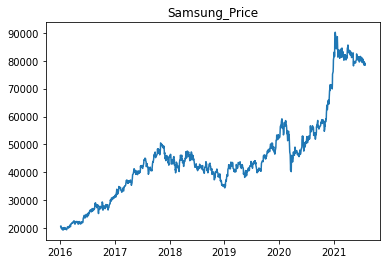

In [ ]:
plt.plot(df_samsung)
plt.title('Samsung_Price')

In [ ]:
#Determine rolling statistics
rolmean_AC = df_samsung['Adj Close'].rolling(window=21).mean() 
#window size 12 denotes 12 days, giving rolling mean at daily level
rolstd_AC = df_samsung['Adj Close'].rolling(window=21).std()

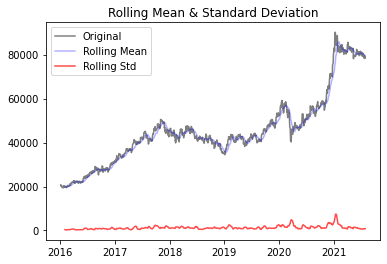

In [ ]:
orig = plt.plot(df_samsung['Adj Close'], color='black', label='Original', alpha=0.5)
mean = plt.plot(rolmean_AC, color='blue', label='Rolling Mean', alpha=0.3)
std = plt.plot(rolstd_AC, color='red', label='Rolling Std', alpha=0.7)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

## 1-2. stationary test of raw data (ADF, KPSS)

- ADF의 귀무가설 : stationary (p-value : lower is better)
- KPSS의 귀무가설 : non-stationary (p-value : higher is better)
  - 참고로, KPSS의 p-value는 최대 0.1, 최소 0.01로 경계가 미리 지정되어 있음.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', lags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [ ]:
adf_test(df_samsung["Adj Close"])

Results of Dickey-Fuller Test:
Test Statistic                   -0.575657
p-value                           0.876388
#Lags Used                       18.000000
Number of Observations Used    1344.000000
Critical Value (1%)              -3.435225
Critical Value (5%)              -2.863693
Critical Value (10%)             -2.567916
dtype: float64


In [ ]:
kpss_test(df_samsung["Adj Close"])

Results of KPSS Test:
Test Statistic            4.59806
p-value                   0.01000
Lags Used                21.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



- ADF
  - 0.87로 p-value가 나왔음. 따라서 해당 데이터는 비정상적으로 볼 수 있음
- KPSS
  - 0.01로 p-value가 나왔음. 따라서 해당 데이터는 비정상적으로 볼 수 있음.

  앞으로 해야할 일은 지수평활화 기법인 차분을 도입하여 데이터를 정상적으로 만들어 볼 것임.
  또한, ARIMA 모형에서는 자동적으로 차분을 진행해준다.

# **2. Build ARIMA model 1 : Data Differencing**

- 차분을 통해 데이터의 stationary를 체크하고 d를 정한다.
- ACF, PACF 검정을 통해서 ARIMA의 p, q를 정한다.

## 2-1. Differencing & stationary test

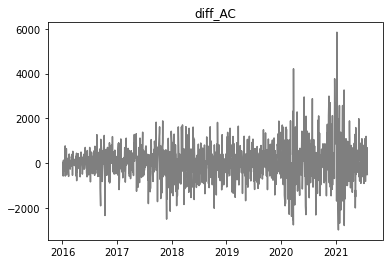

In [ ]:
diff_ACm = df_samsung['Adj Close'].diff(1)
diff_AC = diff_ACm.fillna(0)
plt.plot(diff_AC, color='black', alpha=0.5)
plt.title('diff_AC')
plt.show()

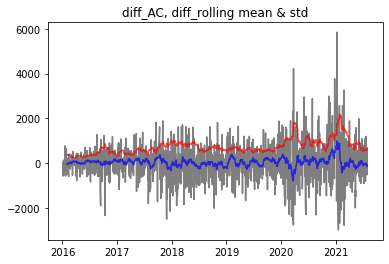

In [ ]:
# makes rolling mean, std plot to differencing likes diff_y

diff_rol_mean_AC = diff_AC.rolling(window=21).mean()
diff_rol_std_AC = diff_AC.rolling(window=21).std()
plt.plot(diff_AC, color='black', alpha=0.5)
plt.plot(diff_rol_mean_AC, color='blue', alpha=0.7)
plt.plot(diff_rol_std_AC, color='red', alpha=0.7)
plt.title('diff_AC, diff_rolling mean & std')
plt.show()

In [ ]:
adf_test(diff_AC)

Results of Dickey-Fuller Test:
Test Statistic                -8.169455e+00
p-value                        8.701976e-13
#Lags Used                     1.700000e+01
Number of Observations Used    1.345000e+03
Critical Value (1%)           -3.435221e+00
Critical Value (5%)           -2.863691e+00
Critical Value (10%)          -2.567915e+00
dtype: float64


In [ ]:
kpss_test(diff_AC)

Results of KPSS Test:
Test Statistic           0.096151
p-value                  0.100000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



## 2-2. ACF, PACF test for diagnosis ARIMA model 1 (p,d,q)



위에서 diff_y의 adf, kpss test 결과치가 좋게 표현되었움.

따라서 1차 차분했던 diff_y를 사용하여 ARIMA를 구축하고자 함.

하지만, ARIMA(p,d,q)에서 d=1이지만 p, q가 지정되어 있지 않음.

그래서 ACF, PACF를 도출하고 p, q를 구하고자 함.

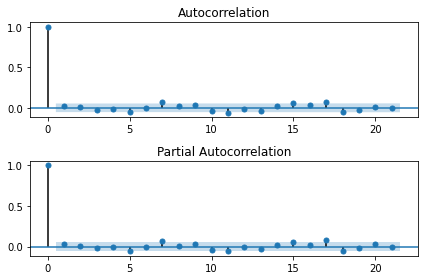

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

N_LAGS = 21
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(diff_AC, ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plot_pacf(diff_AC, ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plt.tight_layout()

## 2-3. ARIMA model 1 by Differencing data





- ADF, KPSS를 통해 d = 1 을 도출할 수 있었다.
- ACF를 통해 q = 1, 2 정도로 추정할 수 있었다.
- PACF를 통해 p = 1, 2 정도로 추정할 수 있었다.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 이번에는 for를 사용하여 최적의 p,q를 찾아보고자 한다.

for i in range(1,3):
  for j in range(1,3):
    model = ARIMA(df_samsung['Adj Close'], order=(i,1,j))
    model_fit1 = model.fit(trend='nc',full_output=True, disp=True, start_ar_lags=i+j)
    print(model_fit1.summary().tables[1])

# ARIMA에서는 자동적으로 차분을 진행하기 때문에 모델 구축시 변수는 원 데이터를 삽입한다.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.Adj Close     0.1931      0.480      0.402      0.688      -0.748       1.134
ma.L1.D.Adj Close    -0.1616      0.482     -0.335      0.738      -1.107       0.784
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.Adj Close    -0.5563      0.409     -1.359      0.174      -1.359       0.246
ma.L1.D.Adj Close     0.5876      0.409      1.435      0.152      -0.215       1.390
ma.L2.D.Adj Close     0.0371      0.028      1.307      0.191      -0.019       0.093
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.Adj Close    -0.5195      0.429     -1.210    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.Adj Close     1.2928      0.057     22.592      0.000       1.181       1.405
ar.L2.D.Adj Close    -0.9307      0.035    -26.453      0.000      -1.000      -0.862
ma.L1.D.Adj Close    -1.2556      0.069    -18.103      0.000      -1.391      -1.120
ma.L2.D.Adj Close     0.8925      0.041     21.749      0.000       0.812       0.973


In [ ]:
model = ARIMA(df_samsung['Adj Close'], order=(2,1,2))
model_fit1 = model.fit(trend='nc',full_output=True, disp=True, start_ar_lags=4)
print(model_fit1.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 1362
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -11016.419
Method:                       css-mle   S.D. of innovations            787.948
Date:                Fri, 03 Sep 2021   AIC                          22042.839
Time:                        06:09:16   BIC                          22068.922
Sample:                             1   HQIC                         22052.603
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.Adj Close     1.2928      0.057     22.592      0.000       1.181       1.405
ar.L2.D.Adj Close    -0.9307      0.035    -26.453      0.000      -1.000      -0.862
ma.L1.D.Adj Close    -1.

AIC 값
- AIC 값은 얼마나 모델이 데이터를 잘 반영했는지에 대한 지표이다.
잘 반영된 모델에 많은 fecture(독립변수)가 사용된다면 이는 높은 AIC값을 가져온다. 반면, 동일한 수준의 모델의 fecture 사용이 적었다면 낮은 AIC를 도출한다.
따라서, 효율성 측면에서 AIC가 낮은 모델이 더 **적합하다고** 볼 수 있다.

Plotting model


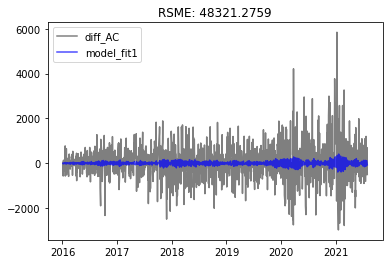

In [ ]:
from sklearn.metrics import mean_squared_error

plt.plot(diff_AC, color='black', alpha=0.5, label='diff_AC')
plt.plot(model_fit1.fittedvalues, color='blue', alpha=0.7, label='model_fit1')
RMSE = mean_squared_error(df_samsung["Adj Close"].iloc[1:], model_fit1.fittedvalues)**0.5
plt.legend(loc='best')
plt.title('RSME: %.4f'%RMSE)
print('Plotting model')

# dep,variable은 종속변수를 의미히는데 우리가 추정할 데이터이다. 
# ARIMA는 차분 등으로 정상화시킨 y변수(diff_y)를 통해서 미래의 y를 예측하는 형태이다.
# 따라서 여기에서 RMSE를 추정하기 위해서는 추정할 데이터(종속변수)인 y와 모형으로 예측한 model_fit을 비교해야 한다.

Text(0.5, 1.0, 'real - predict')

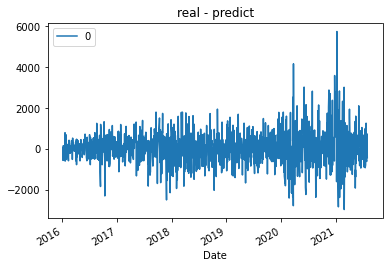

In [ ]:
residuals1 = pd.DataFrame(model_fit1.resid)
residuals1.plot()
plt.title('real - predict')

### 2-3.A. Comparison Predict value with Real value 

In [ ]:
forecast_data1 = model_fit1.forecast(steps=21)

In [ ]:
# 마지막 21일의 예측 데이터 (2021-08-01 ~ 2021-08-31)
pred_arima_AC1 = forecast_data1[0].tolist()
# 해당 forecast의 [0]번째 array에 예측된 가격이 나옴.

# 실제 21일의 데이터 (2021-08-01 ~ 2021-08-31)
test_samsung = yf.download('005930.KS', '2021-08-01', '2021-08-31')['Adj Close']
test_AC1 = pd.DataFrame(test_samsung)

# 마지막 21일의 예측 데이터 최소값
pred_AC1_lower = []
# 마지막 21일의 예측 데이터 최대값
pred_AC1_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_AC1_lower.append(lower)
    pred_AC1_upper.append(upper)

[*********************100%***********************]  1 of 1 completed


In [ ]:
pred_arima_AC1 = pd.DataFrame(np.array(pred_arima_AC1).astype(int))
pred_AC1_lower = np.array(pred_AC1_lower).astype(int)
pred_AC1_upper = np.array(pred_AC1_upper).astype(int)
test_AC1 = test_AC1.values

### 2-3.B. ARIMA model 1's predict accuracy

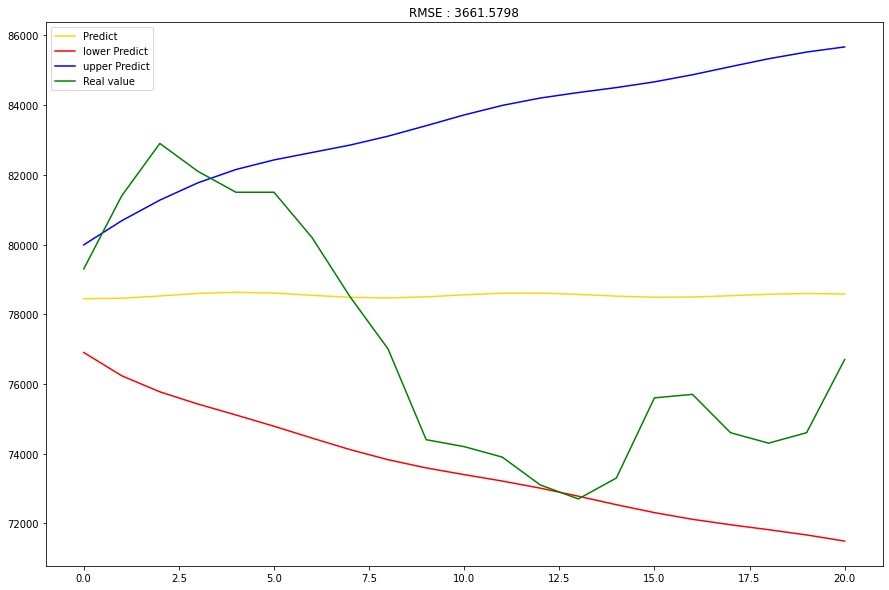

In [ ]:
plt.figure(figsize=(15, 10))

# 모델이 예측한 가격 그래프
plt.plot(pred_arima_AC1, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_AC1_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_AC1_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_AC1, color = 'green')

RMSE = mean_squared_error(test_AC1, pred_arima_AC1)**0.5
plt.legend(['Predict', 'lower Predict','upper Predict','Real value'])
plt.title("RMSE : %.4f" %RMSE)
plt.show()

# **3. Build ARIMA model 2 : Log & Differencing Data**

## 3-1. log + differencing & stationary test

ARIMA 모형의 AIC, RMSE가 높다고 판단됨.

따라서, 이번에는 로그, 차분을 시행해볼 것임. 즉, 변수를 변환하고 다시 ADF,KPSS, ACF, PACF를 보고 ARIMA를 도입할 것임.

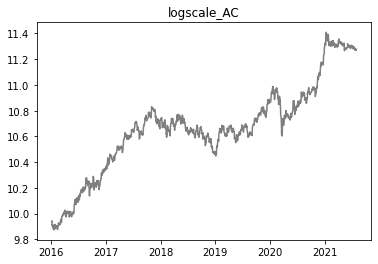

In [ ]:
ln_AC = np.log(df_samsung['Adj Close'])
plt.plot(ln_AC, color='black', alpha=0.5)
plt.title('logscale_AC')
plt.show()

# 원 데이터 로그화

In [ ]:
ln_diff_ACm = ln_AC.diff(1)
ln_diff_AC = ln_diff_ACm.fillna(0)
ln_diff_AC

# 로그로 표현된 데이터의 차분

Date
2016-01-04    0.000000
2016-01-05    0.002486
2016-01-06   -0.027698
2016-01-07   -0.010265
2016-01-08    0.006855
                ...   
2021-07-26   -0.006325
2021-07-27   -0.003814
2021-07-28    0.008878
2021-07-29   -0.002528
2021-07-30   -0.006349
Name: Adj Close, Length: 1363, dtype: float64

In [ ]:
ln_diff_AC.describe()

count    1363.000000
mean        0.000975
std         0.016768
min        -0.083770
25%        -0.008505
50%         0.001071
75%         0.010577
max         0.099579
Name: Adj Close, dtype: float64

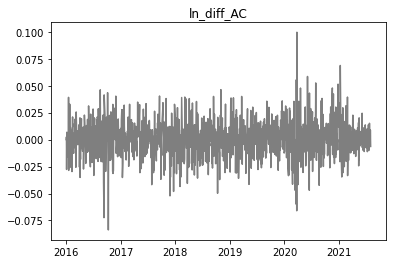

In [ ]:
plt.plot(ln_diff_AC, color='black', alpha=0.5)
plt.title('ln_diff_AC')
plt.show()

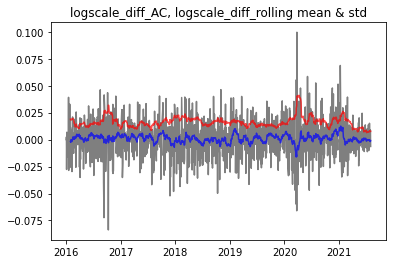

In [ ]:
rolmean_ln_diff_AC = ln_diff_AC.rolling(window=21).mean()
rolstd_ln_diff_AC = ln_diff_AC.rolling(window=21).std()
plt.plot(ln_diff_AC, color='black', alpha=0.5)
plt.plot(rolmean_ln_diff_AC, color='blue', alpha=0.7)
plt.plot(rolstd_ln_diff_AC, color='red', alpha=0.7)
plt.title('logscale_diff_AC, logscale_diff_rolling mean & std')
plt.show()

In [ ]:
adf_test(ln_diff_AC)

Results of Dickey-Fuller Test:
Test Statistic                  -22.044447
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1360.000000
Critical Value (1%)              -3.435167
Critical Value (5%)              -2.863668
Critical Value (10%)             -2.567903
dtype: float64


In [ ]:
kpss_test(ln_diff_AC)

Results of KPSS Test:
Test Statistic           0.091651
p-value                  0.100000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



## 3-2. ACF, PACF test for diagnosis ARIMA model 2 (p,d,q)

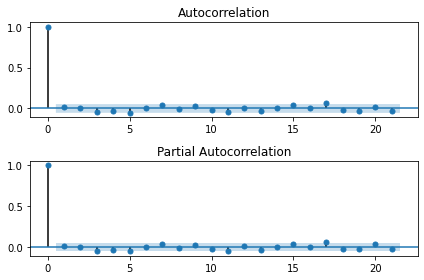

In [ ]:
N_LAGS = 21
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(ln_diff_AC, ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plot_pacf(ln_diff_AC, ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plt.tight_layout()

## 3-3. ARIMA model 2 by Log & Differencing Data

In [ ]:
for i in range(1,3):
  for j in range(1,3):
    model = ARIMA(ln_AC, order=(i,1,j))
    model_fit2 = model.fit(trend='c',full_output=True, disp=True, start_ar_lags=i+j)
    print(model_fit2.summary().tables[1])

# ARIMA는 자동적으로 차분을 하므로, ln으로 치환한 데이터를 넣어준다.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0010      0.000      2.147      0.032     8.5e-05       0.002
ar.L1.D.Adj Close    -0.9921      0.012    -79.680      0.000      -1.017      -0.968
ma.L1.D.Adj Close     0.9950      0.010    102.521      0.000       0.976       1.014


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0010      0.000      2.436      0.015       0.000       0.002
ar.L1.D.Adj Close     0.7990      0.183      4.376      0.000       0.441       1.157
ma.L1.D.Adj Close    -0.7897      0.183     -4.314      0.000      -1.148      -0.431
ma.L2.D.Adj Close    -0.0320      0.027     -1.177      0.239      -0.085       0.021


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0010      0.000      2.433      0.015       0.000       0.002
ar.L1.D.Adj Close     0.8266      0.171      4.831      0.000       0.491       1.162
ar.L2.D.Adj Close    -0.0349      0.028     -1.238      0.216      -0.090       0.020
ma.L1.D.Adj Close    -0.8150      0.169     -4.812      0.000      -1.147      -0.483


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0010      0.000      2.125      0.034    7.61e-05       0.002
ar.L1.D.Adj Close     1.2023      0.026     45.933      0.000       1.151       1.254
ar.L2.D.Adj Close    -0.9665      0.024    -40.233      0.000      -1.014      -0.919
ma.L1.D.Adj Close    -1.1822      0.028    -42.497      0.000      -1.237      -1.128
ma.L2.D.Adj Close     0.9585      0.027     34.985      0.000       0.905       1.012


In [ ]:
model = ARIMA(ln_AC, order=(1,1,1))
model_fit2 = model.fit(trend='c',full_output=True, disp=True, start_ar_lags=2)
print(model_fit2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 1362
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3635.981
Method:                       css-mle   S.D. of innovations              0.017
Date:                Fri, 03 Sep 2021   AIC                          -7263.962
Time:                        06:31:23   BIC                          -7243.095
Sample:                             1   HQIC                         -7256.150
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0010      0.000      2.147      0.032     8.5e-05       0.002
ar.L1.D.Adj Close    -0.9921      0.012    -79.680      0.000      -1.017      -0.968
ma.L1.D.Adj Close     0.

Plotting model


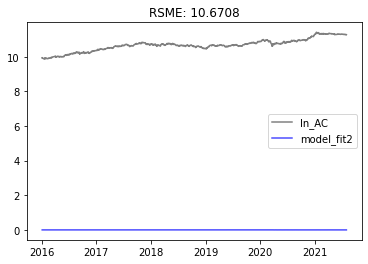

In [ ]:
from sklearn.metrics import mean_squared_error

plt.plot(ln_AC, color='black', alpha=0.5, label='ln_AC')
plt.plot(model_fit2.fittedvalues, color='blue', alpha=0.7, label='model_fit2')
RMSE = mean_squared_error(ln_AC.iloc[1:], model_fit2.fittedvalues)**0.5
plt.legend(loc='best')
plt.title('RSME: %.4f' %RMSE)
print('Plotting model')

# ln_y로 한 이유는 ARIMA를 시행할 때, 입력된 데이터가 ln_y이기 때문임.
# 위의 설명을 참고하면 더 편할 수도 있음.

Text(0.5, 1.0, 'real - predict')

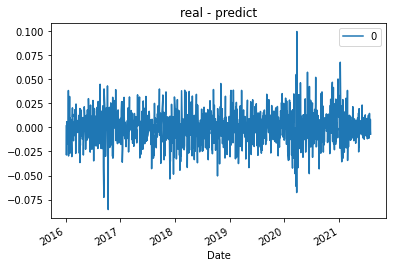

In [ ]:
residuals2 = pd.DataFrame(model_fit2.resid)
residuals2.plot()
plt.title('real - predict')

### 3-3.A. Comparison Predict value with Real value 

In [ ]:
# 마지막 21일의 예측 데이터 (2021-08-01 ~ 2021-08-31)
pred_arima_AC2 = np.exp(forecast_data2[0].tolist())

# 실제 21일의 데이터 (2021-08-01 ~ 2021-08-31)
test_samsung = yf.download('005930.KS', '2021-08-01', '2021-08-31')['Adj Close']
test_AC2 = pd.DataFrame(test_samsung)

# 마지막 5일의 예측 데이터 최소값
pred_AC2_lower = []
# 마지막 5일의 예측 데이터 최대값
pred_AC2_upper = []

for lower_upper in np.exp(forecast_data2[2]):
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_AC2_lower.append(lower)
    pred_AC2_upper.append(upper)

[*********************100%***********************]  1 of 1 completed


In [ ]:
pred_arima_AC2 = pd.DataFrame(np.array(pred_arima_AC2).astype(int))
pred_AC2_lower = pd.DataFrame(np.array(pred_AC2_lower).astype(int))
pred_AC2_upper = pd.DataFrame(np.array(pred_AC2_upper).astype(int))
test_AC2 = test_AC2.values

### 3-3.B. ARIMA model 2's predict accuracy

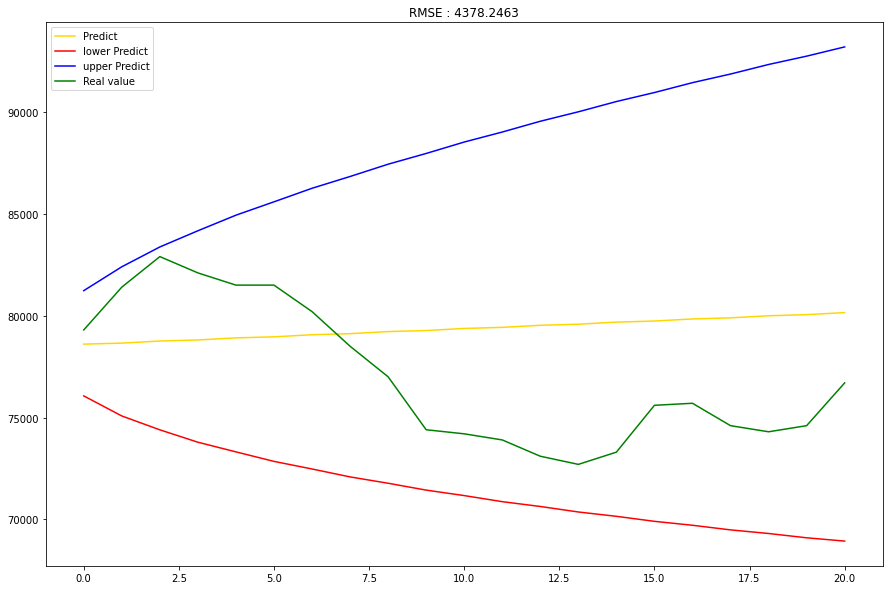

In [ ]:
plt.figure(figsize=(15, 10))

# 모델이 예측한 가격 그래프
plt.plot(pred_arima_AC2, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_AC2_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_AC2_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_AC2, color = 'green')

RMSE = mean_squared_error(test_AC2, pred_arima_AC2)**0.5
plt.legend(['Predict', 'lower Predict','upper Predict','Real value'])
plt.title("RMSE : %.4f" %RMSE)
plt.show()